# Visualising Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from src.data.data_utils import*
# Load into Pandas
df = pd.read_csv("csv_files/qso_full_data.csv")
print(df.head())  # Check the data

        source_id         ra       dec      pmra     pmdec  parallax  \
0   3470333738112  45.075505  0.152316 -1.072371 -3.191011  0.366321   
1   5944234902272  44.884761  0.164806 -0.121274  0.725026 -0.395659   
2   6459630980096  44.910498  0.189649  0.217806 -0.316007 -0.626561   
3   9517648372480  45.254655  0.228999 -0.552941 -1.895446 -0.917219   
4  10892037246720  45.188575  0.282424 -0.098037 -0.120580  0.001630   

   parallax_error      ruwe  phot_g_mean_mag  nu_eff_used_in_astrometry  \
0        0.901633  0.889714        20.571114                   1.526179   
1        1.340139  1.087911        20.704517                   1.647388   
2        0.548536  1.020956        20.173105                        NaN   
3        1.507964  1.031971        20.634562                        NaN   
4        0.246332  0.974657        18.787239                   1.565118   

   pmra_error  pmdec_error  pmra_pmdec_corr  astrometric_params_solved  
0    1.552507     1.226259         0.207769

In this section we are going to reproduce some of the plots presented in the paper [Gaia Early Data Realease 3, Acceleration of the Solar System from Gaia astrometry](https://www.aanda.org/articles/aa/full_html/2021/05/aa39734-20/aa39734-20.html). 

<b>Efficient wavenumber $\nu_{eff}$</b> distribution visualisation:

Separating 5 parmater soultions and 6 parameter soultions

In [2]:
df_5param = df[df["astrometric_params_solved"]==31]
df_6param = df[df["astrometric_params_solved"]==95]
df_5param_filtered = load_filtered_qso_df()

# Checking dimentisons

print(df_5param.shape)
print(df_6param.shape)

(1215942, 14)
(398231, 14)


In [3]:
# Collecting columns individually from dataset df
data_nu_eff = df_5param['nu_eff_used_in_astrometry'].dropna()
data_G = df_5param['phot_g_mean_mag'].dropna()
data_RUWE = df_5param['ruwe'].dropna()
data_RUWE_filtered = df_5param_filtered['ruwe'].dropna()

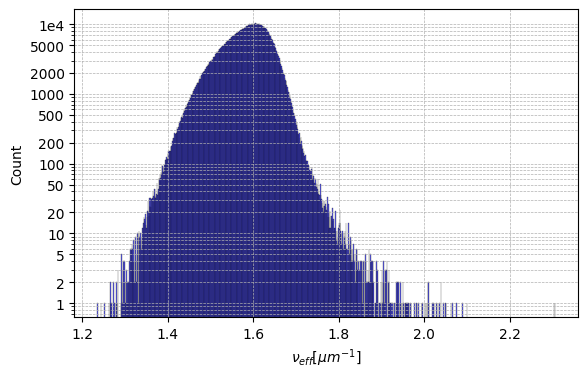

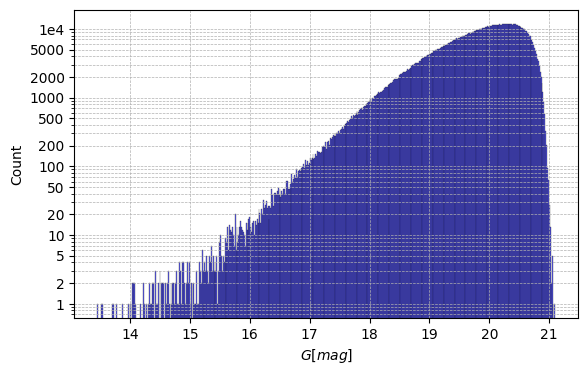

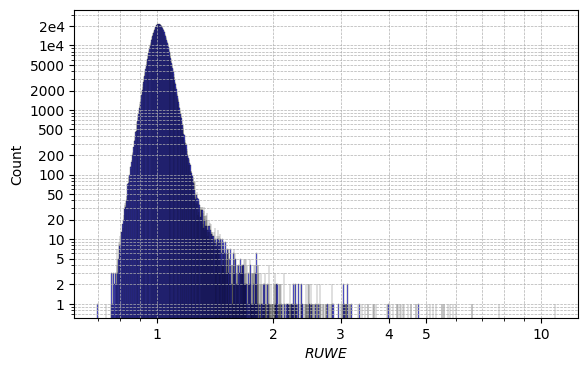

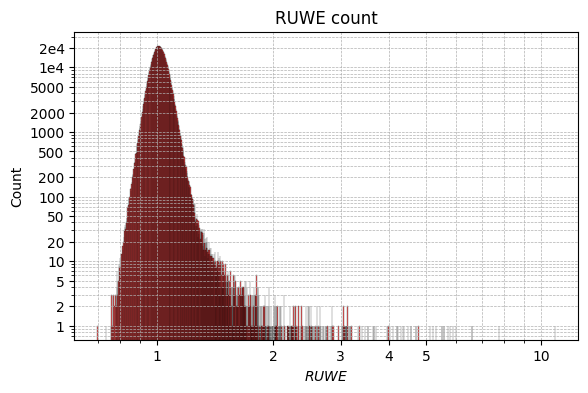

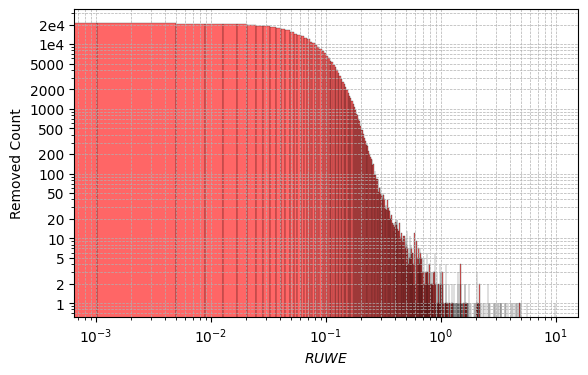

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import LogLocator
import numpy as np

y = [1,2,5,10,20,50,100, 200, 500, 1000, 2000, 5000, 1e4]
label = [1,2,5,10,20,50,100, 200, 500, 1000, 2000, 5000, '1e4']
# Efficient wavenumber plot 
plt.figure(figsize=(6.5, 4))
plt.hist(data_nu_eff, bins=1000, density=False, alpha=0.6, histtype='bar', color='b', edgecolor='black', linewidth=0.3)
plt.yscale('log')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
#plt.title('Efficient wavenumber count')
plt.xlabel(r'$\nu_{eff}[\mu m^{-1}]$')
plt.ylabel('Count')
plt.yticks(y, labels=label)
#plt.savefig("plots/main_plots/eff_wavenumber_count.png", dpi=300, bbox_inches='tight')
plt.show()

# G-band magnitude plot
plt.figure(figsize=(6.5, 4))  
plt.hist(data_G, bins=500, density=False, alpha=0.6, histtype='bar', log=True, color='b', edgecolor='black', linewidth=0.3)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
#plt.title("Mean magnitude in Gaia's G-band count")
plt.xlabel(r'$G[mag]$')
plt.ylabel('Count')
plt.yticks(y, labels=label)
#plt.savefig("plots/main_plots/Gband_count.png", dpi=300, bbox_inches='tight')
plt.show()


# RUWE plot
y = [1,2,5,10,20,50,100, 200, 500, 1000, 2000, 5000, 1e4, 2e4]
label = [1,2,5,10,20,50,100, 200, 500, 1000, 2000, 5000, '1e4', '2e4']
x = [1,2,3,4,5,10]
plt.figure(figsize=(6.5, 4))  
plt.hist(data_RUWE, bins=5000, density=False, alpha=0.6, histtype='bar', log=True, color='b', edgecolor='black', linewidth=0.3)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
#plt.title('RUWE count')
plt.xlabel(r'$RUWE$')
plt.ylabel('Count')
plt.gca().yaxis.set_major_locator(LogLocator(base=10.0, subs=[1.0, 2.0, 5.0], numticks=100))
plt.xscale('log')
plt.xticks(x, labels=x)
plt.yticks(y, labels=label)
#plt.savefig("plots/main_plots/ruwe_count.png", dpi=300, bbox_inches='tight')
plt.show()

plt.figure(figsize=(6.5, 4))  
plt.hist(data_RUWE_filtered, bins=5000, density=False, alpha=0.6, histtype='bar', log=True, color='red', edgecolor='black', linewidth=0.3)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.title('RUWE count')
plt.xlabel(r'$RUWE$')
plt.ylabel('Count')
plt.gca().yaxis.set_major_locator(LogLocator(base=10.0, subs=[1.0, 2.0, 5.0], numticks=100))
plt.xscale('log')
plt.xticks(x, labels=x)
plt.yticks(y, labels=label)
#plt.savefig("plots/main_plots/ruwe_count_filtered.png", dpi=300, bbox_inches='tight')
plt.show()

plt.figure(figsize=(6.5, 4))  
plt.hist(data_RUWE - data_RUWE_filtered, bins=5000, density=False, alpha=0.6, histtype='bar', log=True, color='red', edgecolor='black', linewidth=0.3)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
#plt.title('RUWE count')
plt.xlabel(r'$RUWE$')
plt.ylabel('Removed Count')
plt.gca().yaxis.set_major_locator(LogLocator(base=10.0, subs=[1.0, 2.0, 5.0], numticks=100))
plt.xscale('log')
#plt.xticks(x, labels=x)
plt.yticks(y, labels=label)
#plt.savefig("plots/main_plots/ruwe_count_residual.png", dpi=300, bbox_inches='tight')
plt.show()


In [22]:
# Parrallax, mean and uncertainty
data_parallaxes = df_6param['parallax']
parallax_mean = df_6param['parallax'].mean()
parallax_std = df_6param['parallax'].std()
data_par_error = df_6param['parallax_error']

# Proper motion Right Ascension, mean and uncertainty
data_pmra = df_6param['pmra']
pmra_mean = df_6param['pmra'].mean()
pmra_std = df_6param['pmra'].std()
data_pmra_er = df_6param['pmra_error']

# Proper motion Declination, mean and uncertainty
data_pmdec = df_6param['pmdec']
pmdec_mean = df_6param['pmdec'].mean()
pmdec_std = df_6param['pmdec'].std()
data_pmdec_error = df_6param['pmdec_error']

Parallax, pmra \& pmdec normalised histogram plots

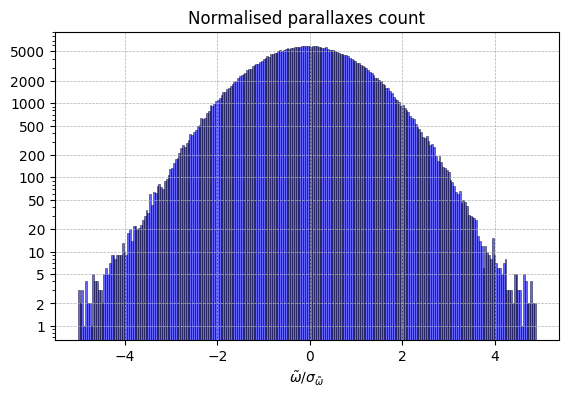

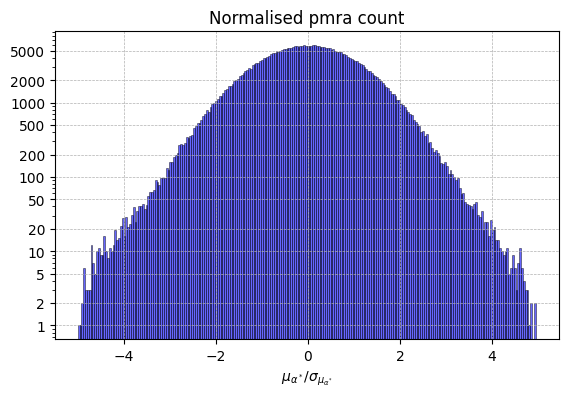

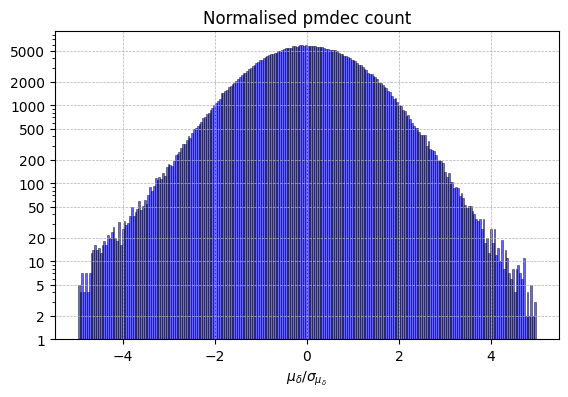

In [ ]:
data1 = (data_parallaxes)/data_par_error  
data2 = (data_pmra)/data_pmra_er
data3 = (data_pmdec)/data_pmdec_error

no_bins = 250


y = [1,2,5,10,20,50,100, 200, 500, 1000, 2000, 5000]

# Parallax
plt.figure(figsize=(6.5, 4))
plt.hist(data1, bins=no_bins, alpha=0.6, color='b', edgecolor='black', linewidth=0.5, log=True)
plt.title('Normalised parallaxes count')
plt.xlabel(r'$\tilde{\omega}/\sigma_{\tilde{\omega}}$')
#plt.ylabel('Count')
plt.grid(True, linestyle='--', linewidth=0.5)
plt.gca().yaxis.set_major_locator(LogLocator(base=10.0, subs=[1.0, 2.0, 5.0], numticks=100))
plt.yticks(y, labels=y)
#plt.savefig("plots/main_plots/Parralax.png", dpi=300, bbox_inches='tight')
plt.show()
# Pmra
plt.figure(figsize=(6.5, 4))
plt.hist(data2, bins=no_bins, alpha=0.6, color='b', edgecolor='black', linewidth=0.5, log=True)
plt.title('Normalised pmra count')
plt.xlabel(r'$\mu_{\alpha^*}/\sigma_{\mu_{\alpha^*}}$')
plt.grid(True, linestyle='--', linewidth=0.5)
plt.yticks(y, labels=y)
#plt.savefig("plots/main_plots/pmra.png", dpi=300, bbox_inches='tight')
plt.show()
# Pmdec
plt.figure(figsize=(6.5, 4))
plt.hist(data3, bins=no_bins, alpha=0.6, color='b', edgecolor='black', linewidth=0.5, log=True)
plt.title('Normalised pmdec count')
plt.xlabel(r'$\mu_{\delta}/\sigma_{\mu_{\delta}}$')
plt.grid(True, linestyle='--', linewidth=0.5)
plt.yticks(y, labels=y)
#plt.savefig("plots/main_plots/pmdec.png", dpi=300, bbox_inches='tight')
plt.show()


/root/Document/Gaia_Project/mem97/gaia_venv/lib/python3.12/site-packages/healpy/visufunc.py:200: UserWarning: Ignoring specified arguments in this call because figure with num: 1 already exists
  f = pylab.figure(fig, figsize=(8.5, 5.4))


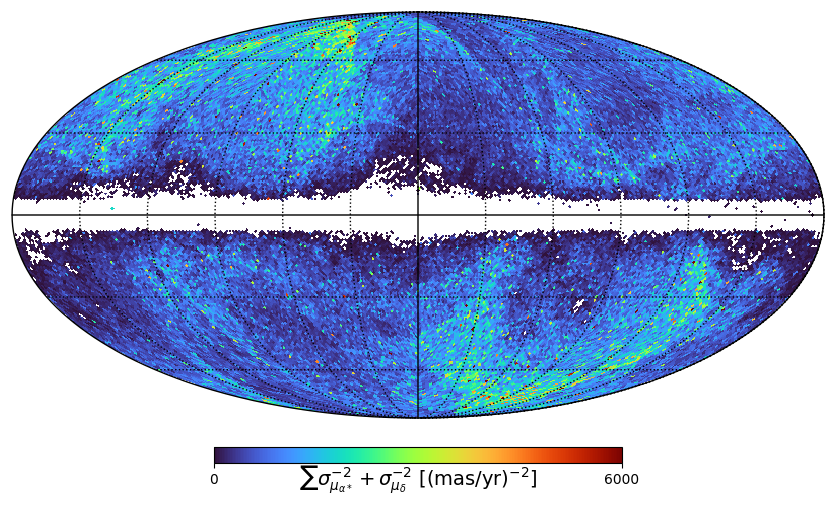

In [ ]:
import healpy as hp
import numpy as np
from astropy.coordinates import SkyCoord
import astropy.units as u
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

# Compute galactic coordinates
coords = SkyCoord(ra=df_5param["ra"].values * u.deg,
                  dec=df_5param["dec"].values * u.deg,
                  frame='icrs')
gal = coords.galactic
l = gal.l.radian  # in radians
b = gal.b.radian  # in radians

# Statistical weights
pmra_error = np.array(df_5param["pmra_error"])
pmdec_error = np.array(df_5param["pmdec_error"])
weights = pmra_error**(-2) + pmdec_error**(-2)

# Apply filtering mask
mask = (weights >= 0) & (weights <= 6000)
l = l[mask]
b = b[mask]
weights = weights[mask]

# HEALPix pixelation
nside = 64
npix = hp.nside2npix(nside)
theta = 0.5 * np.pi - b  # HEALPix theta (colatitude)
phi = l  # HEALPix phi (longitude)
pix = hp.ang2pix(nside, theta, phi)

# Initialise and populate HEALPix map
weight_map = np.zeros(npix)
counts = np.zeros(npix)


for p, w in zip(pix, weights):
    weight_map[p] += w
    counts[p] += 1

    # Convert to weight per steradian
pixel_area_sr = 4*np.pi/npix  # area of one pixel in steradians

m = np.where(counts > 0, weight_map, hp.UNSEEN)
fig = plt.figure(figsize=(8.5, 6))  # square aspect
# Plot using healpy
hp.mollview(m, unit=r"$\sum \sigma_{\mu_{\alpha*}}^{-2} + \sigma_{\mu_{\delta}}^{-2}$ [(mas/yr$)^{-2}$]",
            norm='linear', min=0, max=6000, cmap='turbo', title = '', badcolor = 'white', fig = fig.number)

plt.savefig("plots/main_plots/stat_weight_dist.png", dpi=300, bbox_inches='tight')
hp.graticule()
plt.show()

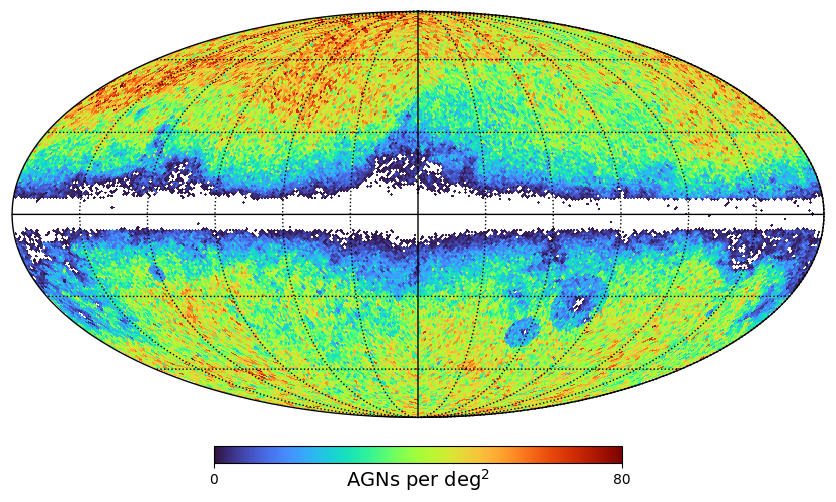

In [ ]:
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
import astropy.units as u

# Galactic coordinates
coords = SkyCoord(ra=df_5param["ra"].values * u.deg,
                  dec=df_5param["dec"].values * u.deg,
                  frame='icrs')
gal = coords.galactic
l = gal.l.radian
b = gal.b.radian

# Healpix binning
nside = 64
npix = hp.nside2npix(nside)
theta = 0.5 * np.pi - b
phi = l
pix = hp.ang2pix(nside, theta, phi)

# Count AGNs per pixel
counts = np.bincount(pix, minlength=npix)

# Convert to counts per deg2
pixel_area_sr = 4*np.pi / npix
sr_to_deg2 = (180/np.pi)**2
pixel_area_deg2 = pixel_area_sr*sr_to_deg2
agn_density = np.where(counts > 0, counts / pixel_area_deg2, hp.UNSEEN)

# Plot using healpy
fig = plt.figure(figsize=(8.5, 6))
hp.mollview(agn_density,
            unit=r"AGNs per deg$^2$",
            min=0, max=80,
            norm='linear',
            cmap='turbo',
            title='',
            badcolor='white',
            fig=fig.number)
hp.graticule()
plt.savefig("plots/main_plots/AGNs_per_deg_sq.png", dpi=300, bbox_inches='tight')
plt.show()


## Reproducting Figure 8

In [2]:
import jax 
import jax.numpy as jnp
from jax import jit, vmap
from src.models.vsh_model import*
from jax import random
import pandas as pd
import gc
from src.models.configuration import*
from numpyro.infer import MCMC, NUTS
import numpyro
import numpyro.distributions as dist
from src.data.data_utils import*
from numpyro.diagnostics import summary

In [3]:
df = load_qso_dataframe() # load full dataset for 5 param solution

### $G_{mag}$
Interested in `phot_g_mean_mag` this will be used to separate the data.

In [10]:
G_mag0 = df[df['phot_g_mean_mag']<=18]                                       # G_mag <= 18
G_mag1 = df[(df['phot_g_mean_mag']>18) & (df['phot_g_mean_mag']<=19)]        # 18 < G_mag <= 19
G_mag2 = df[(df['phot_g_mean_mag'] > 19) & (df['phot_g_mean_mag'] <= 20)]    # 19 < G_mag <= 20
G_mag3 = df[df['phot_g_mean_mag'] > 20]                                      # G_mag > 20

print('Shape dataset for G_mag <= 18',G_mag0.shape)
print('Shape dataset for 18 < G_mag <= 19',G_mag1.shape)
print('Shape dataset for 19 < G_mag <= 20',G_mag2.shape)
print('Shape dataset for G_mag > 20',G_mag3.shape)
G_mag_list = [G_mag0, G_mag1, G_mag2, G_mag3, df] # collecting everthing into a list

Shape dataset for G_mag <= 18 (29200, 14)
Shape dataset for 18 < G_mag <= 19 (146614, 14)
Shape dataset for 19 < G_mag <= 20 (490161, 14)
Shape dataset for G_mag > 20 (549966, 14)


Perform HMC for $l_{max} = 3$

In [4]:
def chi2_jit(angles, obs, error, theta, lmax):
    return least_square(angles, obs, error, theta, lmax=lmax, grid=False)
chi2_jit = jit(chi2_jit, static_argnames=['lmax'])


def model_for_HMC(angles, obs, error, lmax):
    total_params = count_vsh_coeffs(lmax)
    
    # Prior on all VSH coefficients (both toroidal and spheroidal)
    theta = numpyro.sample("theta", dist.Normal(0.0, 1.0).expand([total_params]))
    # Least-squares residuals: we assume Gaussian-distributed residuals
    chi2_val = chi2_jit(angles, obs, error, theta, lmax=lmax)

    # The log-likelihood is proportional to -0.5*chi^2
    numpyro.factor("likelihood", -0.5*chi2_val)

n_s = 4000 # number of samples
n_warmup = 2000 #  number of warmups 
n_chains = 4 # numbe of chains

In [ ]:
rng_key = jax.random.key(0)

kernel = NUTS(model_for_HMC, target_accept_prob=0.75) # this is to make sure acceptance does not exceed 90%

posterior_samples_upper = [] # collect posterior samples based on l
step = 0
for G_mag in G_mag_list:

    print(f'G_mag{step}')
    angles, obs, error = config_data(G_mag)
    # Run sampling algoeithm (HMC)
    mcmc = MCMC(kernel, num_warmup=n_warmup, num_samples=n_s, num_chains=n_chains, chain_method="sequential", progress_bar=True)
    mcmc.run(rng_key, angles = angles, obs = obs, error = error, lmax=3)
    ps = mcmc.get_samples()
    posterior_samples_upper.append(ps)
    
    step += 1

    diagnostics = summary(mcmc.get_samples(group_by_chain=True))
    r_hats = diagnostics['theta']['r_hat']
    avg_r_hat = np.sum(r_hats) / len(r_hats)
    print("Average r_hat:", avg_r_hat)

    divergences = mcmc.get_extra_fields()["diverging"]  # shape: (num_samples * num_chains,)
    num_divergences = divergences.sum()
    print("Number of divergences:", num_divergences)
    
    # Free memory after each iteration
    del mcmc
    del angles
    del obs
    del error
    gc.collect()
    jax.clear_caches()

G_mag0


/tmp/ipykernel_4520/3836863234.py:12: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(kernel, num_warmup=n_warmup, num_samples=n_s, num_chains=n_chains, progress_bar=True)
sample: 100%|██████████| 6000/6000 [01:10<00:00, 85.23it/s, 7 steps of size 2.65e-01. acc. prob=0.85] 


Average r_hat: 0.9999381
Number of divergences: 0
G_mag1


sample: 100%|██████████| 6000/6000 [01:16<00:00, 78.31it/s, 7 steps of size 2.49e-01. acc. prob=0.85]  


Average r_hat: 0.9999596
Number of divergences: 0
G_mag2


sample: 100%|██████████| 6000/6000 [02:07<00:00, 47.03it/s, 7 steps of size 2.79e-01. acc. prob=0.82] 


Average r_hat: 0.9999508
Number of divergences: 0
G_mag3


sample: 100%|██████████| 6000/6000 [02:14<00:00, 44.46it/s, 15 steps of size 3.46e-01. acc. prob=0.87]


Average r_hat: 0.9999783
Number of divergences: 0
G_mag4


sample: 100%|██████████| 6000/6000 [03:11<00:00, 31.36it/s, 7 steps of size 1.54e-01. acc. prob=0.85]  


Average r_hat: 0.9999669
Number of divergences: 0


In [5]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

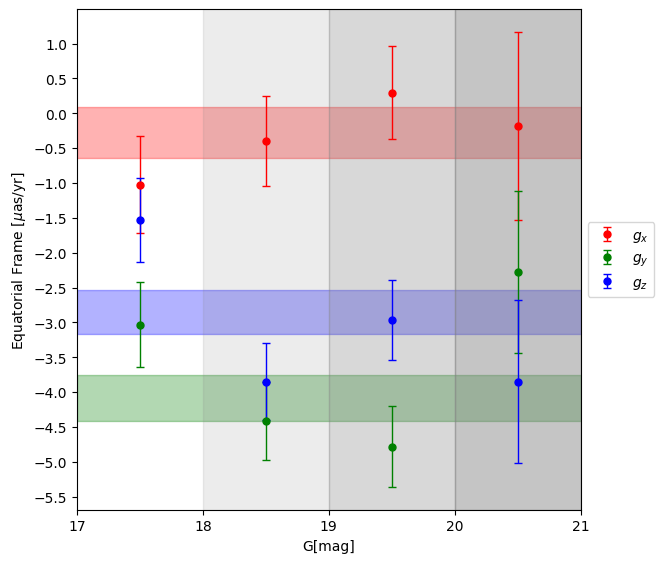

In [ ]:
# For upper panel:
coef_pred = [jnp.mean(ps['theta'], axis=0) for ps in posterior_samples_upper]
std_pred = [jnp.std(ps['theta'], axis=0) for ps in posterior_samples_upper]

G_mag_val = [17.5, 18.5, 19.5, 20.5]
G_mag_label = [17, 18, 19, 20, 21]

C0 = np.sqrt(8*np.pi/3)/1000
C1 = np.sqrt(4*np.pi/3)/1000

# G_mag Vector componets:
gz, gz_error = [coef_pred[z][1]/C0 for z in range(0,4)], [std_pred[z][1]/C0 for z in range(0,4)]
gx, gx_error = [-coef_pred[x][4]/C1 for x in range(0,4)], [std_pred[x][4]/C1 for x in range(0,4)]
gy, gy_error = [coef_pred[y][5]/C1 for y in range(0,4)], [std_pred[y][5]/C1 for y in range(0,4)]

# On full dataset
agz, agz_er = coef_pred[4][1], std_pred[4][1]
agx, agx_er = coef_pred[4][4], std_pred[4][4]
agy, agy_er = coef_pred[4][5], std_pred[4][5]

plt.figure(figsize=(6.5, 6.5))  
plt.errorbar(G_mag_val, gx, yerr=gx_error, fmt='o', capsize=3, markersize=5, elinewidth=1, label=r'$g_x$', color = 'red')
plt.errorbar(G_mag_val, gy, yerr=gy_error, fmt='o', capsize=3, markersize=5, elinewidth=1, label=r'$g_y$', color = 'green')
plt.errorbar(G_mag_val, gz, yerr=gz_error, fmt='o', capsize=3, markersize=5, elinewidth=1, label=r'$g_z$', color = 'blue')

# Plotting bands
plt.axhspan((agz - agz_er)/C0, (agz + agz_er)/C0, color='blue', alpha=0.3)
plt.axhspan((-agx - agx_er)/C1, (-agx + agx_er)/C1, color='red', alpha=0.3)
plt.axhspan((agy - agy_er)/C1, (agy + agy_er)/C1, color='green', alpha=0.3)

# Plotting gray bands
plt.axvspan(18, 19, alpha = 0.15, color = 'gray')
plt.axvspan(19, 20, alpha = 0.3, color = 'gray')
plt.axvspan(20, 21, alpha = 0.45, color = 'gray')

#plt.title("Equatorial Upper Panel")
plt.xlabel(r'G[mag]')
plt.ylabel(r'Equatorial Frame [$\mu$as/yr]')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xticks(G_mag_label, label = G_mag_label)
plt.xlim(17,21)
plt.gca().yaxis.set_major_locator(MultipleLocator(0.5))  # step size 0.5
#plt.savefig("plots/main_plots/G_mag_plot.png", dpi=300, bbox_inches='tight')
plt.show()



## $\nu_{eff}$ Figuire 9.

In [12]:
nu_eff0 = df[df['nu_eff_used_in_astrometry']<=1.55]                                                     # nu_eff <= 1.55          
nu_eff1 = df[(df['nu_eff_used_in_astrometry'] > 1.55) & (df['nu_eff_used_in_astrometry'] <= 1.59)]      # 1.55 < nu_eff <= 1.59
nu_eff2 = df[(df['nu_eff_used_in_astrometry'] > 1.59) & (df['nu_eff_used_in_astrometry'] <= 1.62)]      # 1.59 < nu_eff <= 1.62
nu_eff3 = df[df['nu_eff_used_in_astrometry'] > 1.62]                                                    # nu_eff > 1.62

print('Shape dataset for ν_eff <= 1.55',nu_eff0.shape)
print('Shape dataset for 1.55 < ν_mag <= 1.59',nu_eff1.shape)
print('Shape dataset for 1.59 < ν_mag <= 1.62',nu_eff2.shape)
print('Shape dataset for ν_mag > 1.62',nu_eff3.shape)
nu_eff_list = [nu_eff0, nu_eff1, nu_eff2, nu_eff3, df] # collecting everthing into a list

Shape dataset for ν_eff <= 1.55 (315233, 14)
Shape dataset for 1.55 < ν_mag <= 1.59 (302515, 14)
Shape dataset for 1.59 < ν_mag <= 1.62 (281541, 14)
Shape dataset for ν_mag > 1.62 (316653, 14)


In [7]:
rng_key = jax.random.key(0)

kernel = NUTS(model_for_HMC, target_accept_prob=0.75) # this is to make sure acceptance does not exceed 90%

posterior_samples_upper = [] # collect posterior samples based on l
step = 0
for nu_eff in nu_eff_list:

    print(f'nu_eff{step}')
    angles, obs, error = config_data(nu_eff)
    # Run sampling algoeithm (HMC)
    mcmc = MCMC(kernel, num_warmup=n_warmup, num_samples=n_s, num_chains=n_chains, chain_method="sequential", progress_bar=True)
    mcmc.run(rng_key, angles = angles, obs = obs, error = error, lmax=3)
    ps = mcmc.get_samples()
    posterior_samples_upper.append(ps)
    
    step += 1

    diagnostics = summary(mcmc.get_samples(group_by_chain=True))
    r_hats = diagnostics['theta']['r_hat']
    avg_r_hat = np.sum(r_hats) / len(r_hats)
    print("Average r_hat:", avg_r_hat)

    divergences = mcmc.get_extra_fields()["diverging"]  # shape: (num_samples * num_chains,)
    num_divergences = divergences.sum()
    print("Number of divergences:", num_divergences)
    
    # Free memory after each iteration
    del mcmc
    del angles
    del obs
    del error
    gc.collect()
    jax.clear_caches()

nu_eff0


sample: 100%|██████████| 6000/6000 [01:23<00:00, 71.46it/s, 7 steps of size 3.42e-01. acc. prob=0.86] 


Average r_hat: 0.9998443
Number of divergences: 0
nu_eff1


sample: 100%|██████████| 6000/6000 [01:23<00:00, 71.75it/s, 7 steps of size 2.97e-01. acc. prob=0.87] 


Average r_hat: 0.99986726
Number of divergences: 0
nu_eff2


sample: 100%|██████████| 6000/6000 [01:29<00:00, 66.76it/s, 7 steps of size 2.56e-01. acc. prob=0.87] 


Average r_hat: 0.9999777
Number of divergences: 0
nu_eff3


sample: 100%|██████████| 6000/6000 [02:12<00:00, 45.27it/s, 7 steps of size 2.14e-01. acc. prob=0.84]  


Average r_hat: 1.0000111
Number of divergences: 0
nu_eff4


sample: 100%|██████████| 6000/6000 [03:37<00:00, 27.54it/s, 7 steps of size 1.54e-01. acc. prob=0.85] 


Average r_hat: 0.9999669
Number of divergences: 0


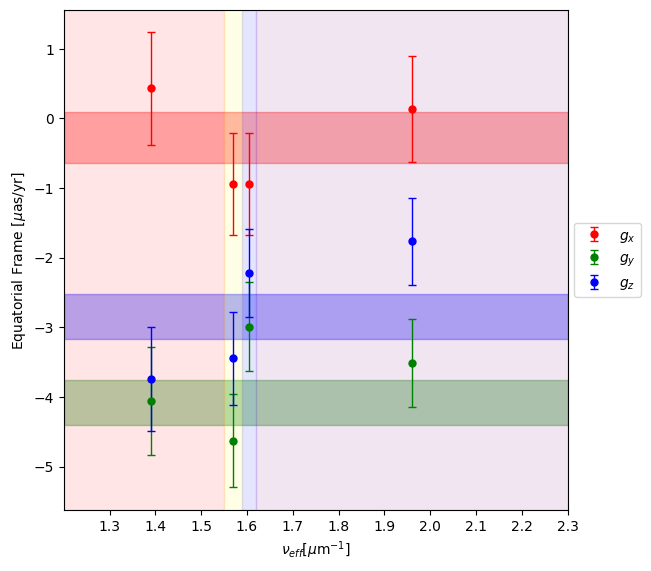

In [ ]:
# For upper panel:
coef_pred = [jnp.mean(ps['theta'], axis=0) for ps in posterior_samples_upper]
std_pred = [jnp.std(ps['theta'], axis=0) for ps in posterior_samples_upper]

nu_eff_val = [1.39, 1.57, 1.605, (1.62+2.3)/2]
nu_eff_label = [1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2., 2.1, 2.2, 2.3]

C0 = np.sqrt(8*np.pi/3)/1000
C1 = np.sqrt(4*np.pi/3)/1000

# G_mag Vector componets:
gz, gz_error = [coef_pred[z][1]/C0 for z in range(0,4)], [std_pred[z][1]/C0 for z in range(0,4)]
gx, gx_error = [-coef_pred[x][4]/C1 for x in range(0,4)], [std_pred[x][4]/C1 for x in range(0,4)]
gy, gy_error = [coef_pred[y][5]/C1 for y in range(0,4)], [std_pred[y][5]/C1 for y in range(0,4)]

# On full dataset
agz, agz_er = coef_pred[4][1], std_pred[4][1]
agx, agx_er = coef_pred[4][4], std_pred[4][4]
agy, agy_er = coef_pred[4][5], std_pred[4][5]

plt.figure(figsize=(6.5, 6.5))  
plt.errorbar(nu_eff_val, gx, yerr=gx_error, fmt='o', capsize=3, markersize=5, elinewidth=1, label=r'$g_x$', color = 'red')
plt.errorbar(nu_eff_val, gy, yerr=gy_error, fmt='o', capsize=3, markersize=5, elinewidth=1, label=r'$g_y$', color = 'green')
plt.errorbar(nu_eff_val, gz, yerr=gz_error, fmt='o', capsize=3, markersize=5, elinewidth=1, label=r'$g_z$', color = 'blue')

# Plotting bands
plt.axhspan((agz - agz_er)/C0, (agz + agz_er)/C0, color='blue', alpha=0.3)
plt.axhspan((-agx - agx_er)/C1, (-agx + agx_er)/C1, color='red', alpha=0.3)
plt.axhspan((agy - agy_er)/C1, (agy + agy_er)/C1, color='green', alpha=0.3)

# Plotting gray bands
plt.axvspan(1.2, 1.55, alpha = 0.1, color = 'red')
plt.axvspan(1.55, 1.59, alpha = 0.1, color = 'yellow')
plt.axvspan(1.59, 1.62, alpha = 0.1, color = 'blue')
plt.axvspan(1.62, 2.3, alpha = 0.1, color = 'purple')

#plt.title("Equatorial Upper Panel")
plt.xlabel(r'$\nu_{eff}$[$\mu \text{m}^{-1}$]')
plt.ylabel(r'Equatorial Frame [$\mu$as/yr]')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xticks(nu_eff_label, label = nu_eff_label)
plt.xlim(1.2, 2.3)
#plt.ylim(-7, 4)
plt.gca().yaxis.set_major_locator(MultipleLocator(1.))
#plt.savefig("plots/main_plots/nu_eff_plot.png", dpi=300, bbox_inches='tight')
plt.show()



### Reproducting figure 7 in Acceleration of the Solar System from Gaia astrometry

In [ ]:
import jax 
import jax.numpy as jnp
import numpy as np
from src.models.vsh_model import*
import pandas as pd
from src.models.configuration import*
from src.data.data_utils import*
import gc

In [ ]:
# Load data
df = load_qso_dataframe()
angles, obs, error = config_data(df)

# Use HMC Sampling

In [ ]:
from numpyro.infer import MCMC, NUTS
import numpyro.distributions as dist
from numpyro.distributions import transforms
import matplotlib.pyplot as plt

In [ ]:
def chi2_jit(angles, obs, error, theta, lmax):
    return least_square(angles, obs, error, theta, lmax=lmax, grid=False)
chi2_jit = jit(chi2_jit, static_argnames=['lmax'])


def model_for_HMC(angles, obs, error, lmax):
    total_params = count_vsh_coeffs(lmax)
    
    # Prior on all VSH coefficients (both toroidal and spheroidal)
    theta = numpyro.sample("theta", dist.Normal(0.0, 1.0).expand([total_params]))
    # Least-squares residuals: we assume Gaussian-distributed residuals
    chi2_val = chi2_jit(angles, obs, error, theta, lmax=lmax)

    # The log-likelihood is proportional to -0.5*chi^2
    numpyro.factor("likelihood", -0.5*chi2_val)

n_s = 4000 # number of samples
n_warmup = 2000 #  number of warmups 
n_chains = 4 # numbe of chains

In [ ]:
rng_key = jax.random.key(0)

kernel = NUTS(model_for_HMC, target_accept_prob=0.75) # this is to make sure acceptance does not exceed 90%

posterior_samples = [] # collect posterior samples based on l
for l in range(1, 8):
    print(f'l = {l}')
    # Run sampling algoeithm (HMC)
    mcmc = MCMC(kernel, num_warmup=n_warmup, num_samples=n_s, num_chains=n_chains, chain_method='sequential', progress_bar=True)
    mcmc.run(rng_key, angles = angles, obs = obs, error = error, lmax=l)
    ps = mcmc.get_samples()
    posterior_samples_upper.append(ps)
    
    # Free memory after each iteration
    del mcmc
    gc.collect()
    jax.clear_caches()

l = 1


sample: 100%|██████████| 3000/3000 [01:24<00:00, 35.51it/s, 7 steps of size 4.82e-01. acc. prob=0.86] 


l = 2


sample: 100%|██████████| 3000/3000 [03:28<00:00, 14.39it/s, 15 steps of size 2.24e-01. acc. prob=0.92]


l = 3


sample: 100%|██████████| 3000/3000 [06:44<00:00,  7.42it/s, 31 steps of size 1.66e-01. acc. prob=0.87]


l = 4


sample: 100%|██████████| 3000/3000 [09:21<00:00,  5.34it/s, 31 steps of size 1.25e-01. acc. prob=0.90]


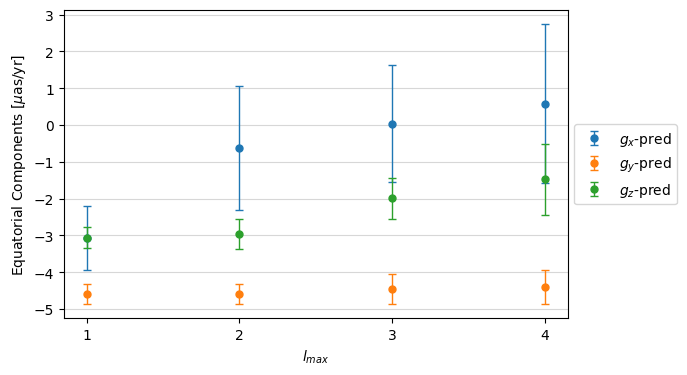

In [ ]:
# For upper panel:
coef_pred_up = [jnp.mean(ps['theta'], axis=0) for ps in posterior_samples]
std_pred_up = [jnp.std(ps['theta'], axis=0) for ps in posterior_samples]

lmax_values = [1, 2, 3, 4, 5, 6, 7]

C0 = np.sqrt(8*np.pi/3)/1000
C1 = np.sqrt(4*np.pi/3)/1000

# Upper panel:
gz_up, gz_error_up = [coef_pred_up[z][1]/C0 for z in range(0,8)], [std_pred_up[z][1]/C0 for z in range(0,8)]
gx_up, gx_error_up = [-coef_pred_up[x][4]/C1 for x in range(0,8)], [std_pred_up[x][4]/C1 for x in range(0,8)]
gy_up, gy_error_up = [coef_pred_up[y][5]/C1 for y in range(0,8)], [std_pred_up[y][5]/C1 for y in range(0,8)]

R_eq_to_gal = np.array([
    [-0.0548755604, -0.8734370902, -0.4838350155],
    [ 0.4941094279, -0.4448296300,  0.7469822445],
    [-0.8676661490, -0.1980763734,  0.4559837762]
])

# Combine into arrays for matrix multiplication
g_eq = np.vstack([gx_up, gy_up, gz_up])  # shape (3, len(lmax))
g_err_eq = np.vstack([gx_error_up, gy_error_up, gz_error_up])

# Apply rotation to vectors
g_gal = R_eq_to_gal @ g_eq        # shape (3, len(lmax))
g_err_gal = np.abs(R_eq_to_gal) @ g_err_eq  # propagate assuming uncorrelated errors

# Unpack transformed components
glx_up, gly_up, glz_up = g_gal
glx_err, gly_err, glz_err = g_err_gal

# Equatorial Plot
plt.figure(figsize=(6.5, 4))  
plt.errorbar(lmax_values, gx_up, yerr=gx_error_up, fmt='o', capsize=3, markersize=5, elinewidth=1, label=r'$g_x$', color = 'red')
plt.errorbar(lmax_values, gy_up, yerr=gy_error_up, fmt='o', capsize=3, markersize=5, elinewidth=1, label=r'$g_y$', color = 'green')
plt.errorbar(lmax_values, gz_up, yerr=gz_error_up, fmt='o', capsize=3, markersize=5, elinewidth=1, label=r'$g_z$', color = 'blue')

plt.xlabel(r'$l_{max}$')
plt.ylabel(r'Equatorial Components [$\mu$as/yr]')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xticks(lmax_values)
plt.grid(axis='y', alpha=0.5)
plt.tight_layout()
plt.savefig("plots/main_plots/fig7.png", dpi=300, bbox_inches='tight')
plt.show()

plt.figure(figsize=(6.5, 4))  
plt.errorbar(lmax_values, glx_up, yerr=glx_err, fmt='o', capsize=3, markersize=5, elinewidth=1, label=r'$g_X$', color = 'red')
plt.errorbar(lmax_values, gly_up, yerr=gly_err, fmt='o', capsize=3, markersize=5, elinewidth=1, label=r'$g_Y$', color = 'green')
plt.errorbar(lmax_values, glz_up, yerr=glz_err, fmt='o', capsize=3, markersize=5, elinewidth=1, label=r'$g_Z$', color = 'blue')

plt.xlabel(r'$l_{max}$')
plt.ylabel(r'Galactic Components [$\mu$as/yr]')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xticks(lmax_values)
plt.grid(axis='y', alpha=0.5)
plt.tight_layout()
plt.savefig("plots/main_plots/fig7_galactic.png", dpi=300, bbox_inches='tight')
plt.show()
